# LIGHT GCN MODEL FOR SCIENTIFIC PAPER RECOMMENDATION




## Load Dataset and Global settings and imports

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
data = pd.read_csv('/content/drive/MyDrive/Buom/ver4/Author_Cite_Paper.csv')
print(data.head(20))

    author_id  paper_id  year_citation
0          26         1           1984
1          26      7824           1984
2          26     15509           2000
3          26     23165           1975
4          26     23165           1979
5          26     23165           1981
6          26     23165           1982
7          26     25208           2005
8          26     25510           2000
9          26     25542           1996
10         26     25581           2000
11         26     25643           1996
12         26     25643           1998
13         26     25808           1992
14         26     25852           1988
15         26     25852           1989
16         26     25852           1989
17         26     25852           1990
18         26     25852           1992
19         26     25852           1996


In [3]:
# Open the file using pandas
paper_data = pd.read_csv('/content/drive/MyDrive/Buom/ver4/Paper.csv')
print(paper_data.head(20))

    paper_id                                              title  \
0          1  Computers and Intractability: A Guide to the T...   
1       2860  Substructure similarity search in graph databases   
2       2884  Inferring AS Relationships: Dead End or Lively...   
3       2885  Bidimensionality: new connections between FPT ...   
4       2892  Hardness of the Undirected Edge-Disjoint Paths...   
5       2899     Aggregate operators in probabilistic databases   
6       2920  Multicommodity flow, well-linked terminals, an...   
7       2953  Optimal Component Composition for Scalable Str...   
8       2968  Constrained Bandwidth Allocation in MultiSenso...   
9       3178  A dissimilarity-based approach for Classification   
10      3247  Scheduling Queries to Improve the Freshness of...   
11      3265  Improving Genome Rearrangement Phylogeny Using...   
12      3449         Data embedding techniques and applications   
13      3472  Patternhunter Ii: Highly Sensitive and Fast Ho..

In [4]:
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-geometric
import torch
from torch import nn, optim, Tensor
from torch_sparse import SparseTensor, matmul
from torch_geometric.utils import structured_negative_sampling
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import Adj

import re

print(f"System version: {sys.version}")
print(f"Pandas version: {pd.__version__}")
print(f"Tensorflow version: {tf.__version__}")

Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp310-cp310-linux_x86_64.whl size=2659115 sha256=ba0196c97a3187ee88396ea86c69912f67d964786f6bfa424d295af2b980736a
  Stored in directory: /root/.cache/pip/wheels/c9/dd/0f/a6a16f9f3b0236733d257b4b4ea91b548b984a341ed3b8f38c
Successfully built torch-sparse
Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl size=3571332 sha256=8ea613d08902df199420614e5e505c9b33c1e158c1eed74508b769c4939d31d8
  Stored in directory: /root/.cache/pip/wheels/92/f1/2b/3b46d54b134259f58c8363568569053248040859b1a145b3ce
Successfully built 

## Preprocessing Data

In [5]:
# load author and paper nodes
def load_node_csv(data, index_col):
    """Loads csv containing node information

    Args:
        data (dataframe): dataframe converted from csv file
        index_col (str): column name of index column

    Returns:
        dict: mapping of csv row to node id
    """
    df = data
    mapping = {index: i for i, index in enumerate(df[index_col].unique())}
    return mapping


author_mapping = load_node_csv(data, index_col='author_id')
paper_mapping = load_node_csv(paper_data, index_col='paper_id')

In [6]:
# load edges between author and paper - interaction: citation
def load_edge_csv(data, src_index_col, src_mapping, dst_index_col, dst_mapping):
    """Loads csv containing edges between users and items

    Args:
        data (dataframe): dataframe converted from csv file
        src_index_col (str): column name of users
        src_mapping (dict): mapping between row number and user id
        dst_index_col (str): column name of items
        dst_mapping (dict): mapping between row number and item id
    Returns:
        torch.Tensor: 2 by N matrix containing the node ids of N user-item edges
    """
    df = data
    src = [src_mapping[index] for index in df[src_index_col]]
    dst = [dst_mapping[index] for index in df[dst_index_col]]

    edge_index = [[], []]
    for i in range(df.shape[0]):
        edge_index[0].append(src[i])
        edge_index[1].append(dst[i])

    return torch.tensor(edge_index)


edge_index = load_edge_csv(
    data,
    src_index_col='author_id',
    src_mapping=author_mapping,
    dst_index_col='paper_id',
    dst_mapping=paper_mapping,
)

## Split Data

In [7]:
# split the edges of the graph using a 80/10/10 train/validation/test split
num_authors, num_papers = len(author_mapping), len(paper_mapping)
num_interactions = edge_index.shape[1]
all_indices = [i for i in range(num_interactions)]

train_indices, test_indices = train_test_split(
    all_indices, test_size=0.2, random_state=1)
val_indices, test_indices = train_test_split(
    test_indices, test_size=0.5, random_state=1)

train_edge_index = edge_index[:, train_indices]
val_edge_index = edge_index[:, val_indices]
test_edge_index = edge_index[:, test_indices]

In [8]:
# convert edge indices into Sparse Tensors: https://pytorch-geometric.readthedocs.io/en/latest/notes/sparse_tensor.html
train_sparse_edge_index = SparseTensor(row=train_edge_index[0], col=train_edge_index[1], sparse_sizes=(
    num_authors + num_papers, num_authors + num_papers))
val_sparse_edge_index = SparseTensor(row=val_edge_index[0], col=val_edge_index[1], sparse_sizes=(
    num_authors + num_papers, num_authors + num_papers))
test_sparse_edge_index = SparseTensor(row=test_edge_index[0], col=test_edge_index[1], sparse_sizes=(
    num_authors + num_papers, num_authors + num_papers))

In [9]:
# function which random samples a mini-batch of positive and negative samples
def sample_mini_batch(batch_size, edge_index):
    """Randomly samples indices of a minibatch given an adjacency matrix

    Args:
        batch_size (int): minibatch size
        edge_index (torch.Tensor): 2 by N list of edges

    Returns:
        tuple: user indices, positive item indices, negative item indices
    """
    edges = structured_negative_sampling(edge_index)
    edges = torch.stack(edges, dim=0)
    indices = random.choices(
        [i for i in range(edges[0].shape[0])], k=batch_size)
    batch = edges[:, indices]
    user_indices, pos_item_indices, neg_item_indices = batch[0], batch[1], batch[2]
    return user_indices, pos_item_indices, neg_item_indices

## Create LightGCN Model
Between each layer, LightGCN uses the following propagation rule for user and item embeddings.

\begin{equation}
e_u^{(k+1)} = \sum_{i \in N_u} \frac{1}{\sqrt{|N_u|}\sqrt{|N_i|}} e_i^{(k)} \quad e_i^{(k+1)} = \sum_{u \in N_i} \frac{1}{\sqrt{|N_i|}\sqrt{|N_u|}} e_u^{(k)}
\end{equation}

$N_u$: the set of all neighbors of user $u$ (items liked by $u$)

$N_i$: the set of all neighbors of item $i$ (users who liked $i$)

$e_u^{(k)}$ : k-th layer user embedding

$e_i^{(k)}$ : k-th layer item embedding

The only trainable parameters of LightGCN are the 0-th layer embeddings $e_u^{(0)}$ and $e_i^{(0)}$ for each user and item. We combine the embeddings obtained at each layer of propagation to form the final embeddings for all user and item, $e_u$ and $e_i$ via the follwing equation.


\begin{equation}
e_u = \sum_{k = 0}^K \alpha_k e_u^{(k)} \quad e_i = \sum_{k = 0}^K \alpha_k e_i^{(k)}
\end{equation}

$\alpha_k$ : hyperparameter which weights the contribution of the k-th layer embedding to the final embedding

The model prediction is obtained by taking the inner product of the final user and item embeddings.

\begin{equation}
\hat{y}_{ui} = e_u^Te_i
\end{equation}

#### Matrix Form:
\begin{equation}
E^{(K)} = \alpha_0 E^{(0)} + \alpha_1 \tilde{A}^1 E^{(0)} + \alpha_2 \tilde{A}^2 E^{(0)} + \cdot \cdot \cdot + \alpha_K \tilde{A}^K \tilde{A} E^{(0)}
\end{equation}

$E^{(0)} \in \mathcal{R}^{(M + N)} \times T$ : stacked initial item and user embeddings where $M$, $N$, and $T$ denote the number of users, number of items, and the dimension of each embedding respectively

$\tilde{A} = D^{-\frac{1}{2}}AD^{-\frac{1}{2}}$ : symmetrically normalized adjacency matrix



In [10]:
# defines LightGCN model
class LightGCN(MessagePassing):
    def __init__(self, num_users, num_items, embedding_dim=64, K=2, add_self_loops=False):
        """Initializes LightGCN Model

        Args:
            num_users (int): Number of users
            num_items (int): Number of items
            embedding_dim (int, optional): Dimensionality of embeddings. Defaults to 8.
            K (int, optional): Number of message passing layers. Defaults to 3.
            add_self_loops (bool, optional): Whether to add self loops for message passing. Defaults to False.
        """
        super().__init__()
        self.num_users, self.num_items = num_users, num_items
        self.embedding_dim, self.K = embedding_dim, K
        self.add_self_loops = add_self_loops

        self.users_emb = nn.Embedding(
            num_embeddings=self.num_users, embedding_dim=self.embedding_dim) # e_u^0
        self.items_emb = nn.Embedding(
            num_embeddings=self.num_items, embedding_dim=self.embedding_dim) # e_i^0

        nn.init.normal_(self.users_emb.weight, std=0.1)
        nn.init.normal_(self.items_emb.weight, std=0.1)

    def forward(self, edge_index: SparseTensor):
        """Forward propagation of LightGCN Model.

        Args:
            edge_index (SparseTensor): adjacency matrix

        Returns:
            tuple (Tensor): e_u_k, e_u_0, e_i_k, e_i_0
        """
        # compute \tilde{A}: symmetrically normalized adjacency matrix
        edge_index_norm = gcn_norm(
            edge_index, add_self_loops=self.add_self_loops)

        emb_0 = torch.cat([self.users_emb.weight, self.items_emb.weight]) # E^0
        embs = [emb_0]
        emb_k = emb_0

        # multi-scale diffusion
        for i in range(self.K):
            emb_k = self.propagate(edge_index_norm, x=emb_k)
            embs.append(emb_k)

        embs = torch.stack(embs, dim=1)
        emb_final = torch.mean(embs, dim=1) # E^K

        users_emb_final, items_emb_final = torch.split(
            emb_final, [self.num_users, self.num_items]) # splits into e_u^K and e_i^K

        # returns e_u^K, e_u^0, e_i^K, e_i^0
        return users_emb_final, self.users_emb.weight, items_emb_final, self.items_emb.weight

    def message(self, x_j: Tensor) -> Tensor:
        return x_j

    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        # computes \tilde{A} @ x
        return matmul(adj_t, x)

model = LightGCN(num_authors, num_papers)

## Loss Function
Bayesian Personalized Ranking (BPR) loss, a pairwise objective which encourages the predictions of positive samples to be higher than negative samples for each user.

\begin{equation}
L_{BPR} = -\sum_{u = 1}^M \sum_{i \in N_u} \sum_{j \notin N_u} \ln{\sigma(\hat{y}_{ui} - \hat{y}_{uj})} + \lambda ||E^{(0)}||^2
\end{equation}

$\hat{y}_{u}$: predicted score of a positive sample

$\hat{y}_{uj}$: predicted score of a negative sample

$\lambda$: hyperparameter which controls the L2 regularization strength

In [11]:
def bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, lambda_val):
    """
    Args:
        users_emb_final (torch.Tensor): e_u_k
        users_emb_0 (torch.Tensor): e_u_0
        pos_items_emb_final (torch.Tensor): positive e_i_k
        pos_items_emb_0 (torch.Tensor): positive e_i_0
        neg_items_emb_final (torch.Tensor): negative e_i_k
        neg_items_emb_0 (torch.Tensor): negative e_i_0
        lambda_val (float): lambda value for regularization loss term

    Returns:
        torch.Tensor: scalar bpr loss value
    """
    reg_loss = lambda_val * (users_emb_0.norm(2).pow(2) +
                             pos_items_emb_0.norm(2).pow(2) +
                             neg_items_emb_0.norm(2).pow(2)) # L2 loss

    pos_scores = torch.mul(users_emb_final, pos_items_emb_final)
    pos_scores = torch.sum(pos_scores, dim=-1) # predicted scores of positive samples
    neg_scores = torch.mul(users_emb_final, neg_items_emb_final)
    neg_scores = torch.sum(neg_scores, dim=-1) # predicted scores of negative samples

    loss = -torch.mean(torch.nn.functional.softplus(pos_scores - neg_scores)) + reg_loss

    return loss

## Evaluation Model

In [12]:
# computes recall@K and precision@K
def RecallPrecision_ATk(groundTruth, r, k):
    """Computers recall @ k and precision @ k

    Args:
        groundTruth (list): list of lists containing highly rated items of each user
        r (list): list of lists indicating whether each top k item recommended to each user
            is a top k ground truth item or not
        k (intg): determines the top k items to compute precision and recall on

    Returns:
        tuple: recall @ k, precision @ k
    """
    num_correct_pred = torch.sum(r, dim=-1)  # number of correctly predicted items per user
    # number of items liked by each user in the test set
    user_num_liked = torch.Tensor([len(groundTruth[i])
                                  for i in range(len(groundTruth))])
    recall = torch.mean(num_correct_pred / user_num_liked)
    precision = torch.mean(num_correct_pred) / k
    return recall.item(), precision.item()

# computes NDCG@K
def NDCGatK_r(groundTruth, r, k):
    """Computes Normalized Discounted Cumulative Gain (NDCG) @ k

    Args:
        groundTruth (list): list of lists containing highly rated items of each user
        r (list): list of lists indicating whether each top k item recommended to each user
            is a top k ground truth item or not
        k (int): determines the top k items to compute ndcg on

    Returns:
        float: ndcg @ k
    """
    assert len(r) == len(groundTruth)

    test_matrix = torch.zeros((len(r), k))

    for i, items in enumerate(groundTruth):
        length = min(len(items), k)
        test_matrix[i, :length] = 1
    max_r = test_matrix
    idcg = torch.sum(max_r * 1. / torch.log2(torch.arange(2, k + 2)), axis=1)
    dcg = r * (1. / torch.log2(torch.arange(2, k + 2)))
    dcg = torch.sum(dcg, axis=1)
    idcg[idcg == 0.] = 1.
    ndcg = dcg / idcg
    ndcg[torch.isnan(ndcg)] = 0.
    return torch.mean(ndcg).item()

# wrapper function to get evaluation metrics
def get_metrics(model, edge_index, exclude_edge_indices, k):
    """Computes the evaluation metrics: recall, precision, and ndcg @ k

    Args:
        model (LighGCN): lightgcn model
        edge_index (torch.Tensor): 2 by N list of edges for split to evaluate
        exclude_edge_indices ([type]): 2 by N list of edges for split to discount from evaluation
        k (int): determines the top k items to compute metrics on

    Returns:
        tuple: recall @ k, precision @ k, ndcg @ k
    """
    user_embedding = model.users_emb.weight
    item_embedding = model.items_emb.weight

    # get ratings between every user and item - shape is num users x num movies
    rating = torch.matmul(user_embedding, item_embedding.T)

    for exclude_edge_index in exclude_edge_indices:
        # gets all the positive items for each user from the edge index
        user_pos_items = get_user_positive_items(exclude_edge_index)
        # get coordinates of all edges to exclude
        exclude_users = []
        exclude_items = []
        for user, items in user_pos_items.items():
            exclude_users.extend([user] * len(items))
            exclude_items.extend(items)

        # set ratings of excluded edges to large negative value
        rating[exclude_users, exclude_items] = -(1 << 10)

    # get the top k recommended items for each user
    _, top_K_items = torch.topk(rating, k=k)

    # get all unique users in evaluated split
    users = edge_index[0].unique()

    test_user_pos_items = get_user_positive_items(edge_index)

    # convert test user pos items dictionary into a list
    test_user_pos_items_list = [
        test_user_pos_items[user.item()] for user in users]

    # determine the correctness of topk predictions
    r = []
    for user in users:
        ground_truth_items = test_user_pos_items[user.item()]
        label = list(map(lambda x: x in ground_truth_items, top_K_items[user]))
        r.append(label)
    r = torch.Tensor(np.array(r).astype('float'))

    recall, precision = RecallPrecision_ATk(test_user_pos_items_list, r, k)
    ndcg = NDCGatK_r(test_user_pos_items_list, r, k)

    return recall, precision, ndcg

In [13]:
# wrapper function to evaluate model
def evaluation(model, edge_index, sparse_edge_index, exclude_edge_indices, k, lambda_val):
    """Evaluates model loss and metrics including recall, precision, ndcg @ k

    Args:
        model (LighGCN): lightgcn model
        edge_index (torch.Tensor): 2 by N list of edges for split to evaluate
        sparse_edge_index (sparseTensor): sparse adjacency matrix for split to evaluate
        exclude_edge_indices ([type]): 2 by N list of edges for split to discount from evaluation
        k (int): determines the top k items to compute metrics on
        lambda_val (float): determines lambda for bpr loss

    Returns:
        tuple: bpr loss, recall @ k, precision @ k, ndcg @ k
    """
    # get embeddings
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(
        sparse_edge_index)
    edges = structured_negative_sampling(
        edge_index, contains_neg_self_loops=False)
    user_indices, pos_item_indices, neg_item_indices = edges[0], edges[1], edges[2]
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[
        pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[
        neg_item_indices], items_emb_0[neg_item_indices]

    loss = bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0,
                    neg_items_emb_final, neg_items_emb_0, lambda_val).item()

    recall, precision, ndcg = get_metrics(
        model, edge_index, exclude_edge_indices, k)

    return loss, recall, precision, ndcg

## Train Model

In [14]:
# define contants
ITERATIONS = 1000
BATCH_SIZE = 1024
LR = 5e-4
ITERS_PER_EVAL = 50
ITERS_PER_LR_DECAY = 50
K = 8
LAMBDA = 1e-5

In [15]:
# setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {device}.")


model = model.to(device)
model.train()

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
train_sparse_edge_index = train_sparse_edge_index.to(device)

val_edge_index = val_edge_index.to(device)
val_sparse_edge_index = val_sparse_edge_index.to(device)

Using device cuda.


In [16]:
# helper function to get N_u
def get_user_positive_items(edge_index):
    """Generates dictionary of positive items for each user
    Args:
        edge_index (torch.Tensor): 2 by N list of edges

    Returns:
        dict: dictionary of positive items for each user
    """
    user_pos_items = {}
    for i in range(edge_index.shape[1]):
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()
        if user not in user_pos_items:
            user_pos_items[user] = []
        user_pos_items[user].append(item)
    return user_pos_items

In [17]:
# training loop
train_losses = []
val_losses = []

for iter in range(ITERATIONS):
    # forward propagation
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(
        train_sparse_edge_index)

    # mini batching
    user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(
        BATCH_SIZE, train_edge_index)
    user_indices, pos_item_indices, neg_item_indices = user_indices.to(
        device), pos_item_indices.to(device), neg_item_indices.to(device)
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[
        pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[
        neg_item_indices], items_emb_0[neg_item_indices]

    # loss computation
    train_loss = bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final,
                          pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, LAMBDA)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    if iter % ITERS_PER_EVAL == 0:
        model.eval()
        val_loss, recall, precision, ndcg = evaluation(
            model, val_edge_index, val_sparse_edge_index, [train_edge_index], K, LAMBDA)
        print(f"[Iteration {iter}/{ITERATIONS}] train_loss: {round(train_loss.item(), 5)}, val_loss: {round(val_loss, 5)}, val_recall@{K}: {round(recall, 5)}, val_precision@{K}: {round(precision, 5)}, val_ndcg@{K}: {round(ndcg, 5)}")
        train_losses.append(train_loss.item())
        val_losses.append(val_loss)
        model.train()

    if iter % ITERS_PER_LR_DECAY == 0 and iter != 0:
        scheduler.step()


[Iteration 0/1000] train_loss: -0.67405, val_loss: -0.66282, val_recall@8: 0.0, val_precision@8: 0.0, val_ndcg@8: 0.0
[Iteration 50/1000] train_loss: -0.6782, val_loss: -0.66763, val_recall@8: 0.0, val_precision@8: 0.0, val_ndcg@8: 0.0
[Iteration 100/1000] train_loss: -0.68111, val_loss: -0.67093, val_recall@8: 0.0, val_precision@8: 0.0, val_ndcg@8: 0.0
[Iteration 150/1000] train_loss: -0.68317, val_loss: -0.67312, val_recall@8: 0.0, val_precision@8: 0.0, val_ndcg@8: 0.0
[Iteration 200/1000] train_loss: -0.68504, val_loss: -0.67472, val_recall@8: 0.0, val_precision@8: 0.0, val_ndcg@8: 0.0
[Iteration 250/1000] train_loss: -0.68735, val_loss: -0.67591, val_recall@8: 0.0, val_precision@8: 0.0, val_ndcg@8: 0.0
[Iteration 300/1000] train_loss: -0.68962, val_loss: -0.67682, val_recall@8: 0.0, val_precision@8: 0.0, val_ndcg@8: 0.0
[Iteration 350/1000] train_loss: -0.69203, val_loss: -0.67761, val_recall@8: 0.0, val_precision@8: 0.0, val_ndcg@8: 0.0
[Iteration 400/1000] train_loss: -0.69694, v

In [18]:
# Save the embedding weight for later use e_u and e_i
users_embeddings = model.users_emb.weight.detach().cpu().numpy()
items_embeddings = model.items_emb.weight.detach().cpu().numpy()
np.save('/content/drive/MyDrive/Buom/ver4/light_gcn_users_embeddings.npy', users_embeddings)
np.save('/content/drive/MyDrive/Buom/ver4/light_gcn_items_embeddings.npy', items_embeddings)

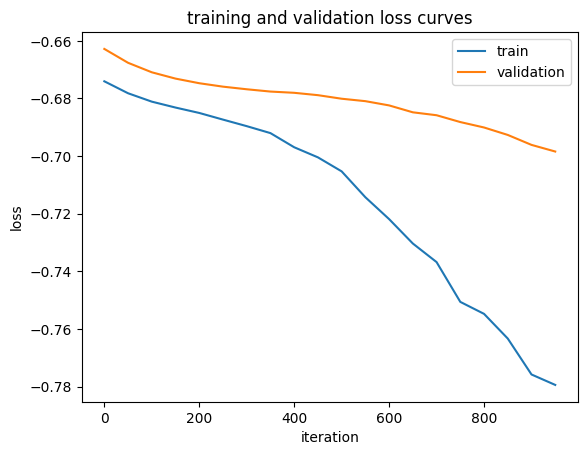

In [19]:
iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
plt.plot(iters, train_losses, label='train')
plt.plot(iters, val_losses, label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('training and validation loss curves')
plt.legend()
plt.show()

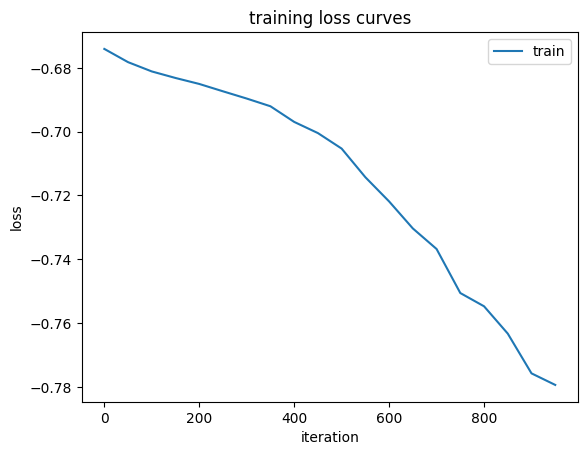

In [20]:
iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
plt.plot(iters, train_losses, label='train')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('training loss curves')
plt.legend()
plt.show()

In [21]:
# evaluate on test set
model.eval()
test_edge_index = test_edge_index.to(device)
test_sparse_edge_index = test_sparse_edge_index.to(device)

test_loss, test_recall, test_precision, test_ndcg = evaluation(
            model, test_edge_index, test_sparse_edge_index, [train_edge_index, val_edge_index], K, LAMBDA)

print(f"[test_loss: {round(test_loss, 5)}, test_recall@{K}: {round(test_recall, 5)}, test_precision@{K}: {round(test_precision, 5)}, test_ndcg@{K}: {round(test_ndcg, 5)}")

[test_loss: -0.70022, test_recall@8: 0.0008, test_precision@8: 0.01042, test_ndcg@8: 0.00908


## Make Recommendation for a Given Researcher

In [22]:
model.eval()
df = paper_data
paperid_titles = pd.Series(df.title.values,index=df.paper_id).to_dict()
paperid_abstracts = pd.Series(df.abstract.values,index=df.paper_id).to_dict()
user_pos_items = get_user_positive_items(edge_index)

In [23]:
# Fixing
def make_predictions(author_id, num_recs):
    user = author_mapping[author_id]
    e_u = model.users_emb.weight[user]
    scores = model.items_emb.weight @ e_u

    values, indices = torch.topk(scores, k=len(user_pos_items[user]) + num_recs)

    papers = [index.cpu().item() for index in indices if index in user_pos_items[user]][:num_recs]
    if (num_recs > len(papers)):
        num_recs = len(papers)
    paper_ids = [list(paper_mapping.keys())[list(paper_mapping.values()).index(paper)] for paper in papers]
    titles = [paperid_titles[id] for id in paper_ids]
    abstracts = [paperid_abstracts[id] for id in paper_ids]

    print(f"Here are some paper that author {author_id} is highly interested in")
    for i in range(num_recs):
        print(f"title: {titles[i]}, abstract: {abstracts[i]} ")

    print()

    papers = [index.cpu().item() for index in indices if index not in user_pos_items[user]][:num_recs]
    paper_ids = [list(paper_mapping.keys())[list(paper_mapping.values()).index(paper)] for paper in papers]
    titles = [paperid_titles[id] for id in paper_ids]
    abstracts = [paperid_abstracts[id] for id in paper_ids]

    print(f"Here are some suggested papers for author {author_id}")
    for i in range(num_recs):
        print(f"title: {titles[i]}, abstract: {abstracts[i]} ")

In [24]:
author_mapping

{26: 0,
 186: 1,
 254: 2,
 405: 3,
 513: 4,
 849: 5,
 1019: 6,
 1292: 7,
 1574: 8,
 2010: 9,
 2143: 10,
 2244: 11}

In [26]:
AUTHOR_ID = 26
NUM_RECS = 10
make_predictions(AUTHOR_ID, NUM_RECS)

Here are some paper that author 26 is highly interested in
title: Optimal Point Location in a Monotone Subdivision, abstract: Point location, often known in graphics as "hit detection," is one of the fundamental problems of computational geometry. In a point location query we want to identify which of a given collection of geometric objects contains a particular point. Let denote a subdivision of the Euclidean plane into monotone regions by a straight-line graph of edges. In this paper we exhibit a substantial refinement of the technique of Lee and Preparata [SIAM J. Comput., 6 (1977), pp. 594–606] for locating a point in based on separating chains. The new data structure, called a layered dag, can be built in O(m) time, uses O(m) storage, and makes possible point location in $O(\\log m)$ time. Unlike previous structures that attain these optimal bounds, the layered dag can be implemented in a simple and practical way, and is extensible to subdivisions with edges more general than stra